In [169]:
from webscraping.scraper import fetch_all_csv_from_drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from itertools import combinations



In [28]:
import os
import pandas as pd
from google.oauth2 import service_account
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from io import BytesIO

def fetch_all_csv_from_drive(folder_id, credentials_path):

    SCOPES = ["https://www.googleapis.com/auth/drive"]
    credentials = service_account.Credentials.from_service_account_file(credentials_path, scopes=SCOPES)
    service = build("drive", "v3", credentials=credentials)

    query = f"'{folder_id}' in parents and mimeType='text/csv'"
    all_dataframes = []
    page_token = None

    while True:
        results = service.files().list(
            q=query,
            fields="nextPageToken, files(id, name)",
            pageToken=page_token
        ).execute()

        files = results.get("files", [])
        page_token = results.get("nextPageToken")

        if not files:
            print("No more CSV files found in the folder.")
            break

        for file in files:
            file_id = file["id"]
            file_name = file["name"]

            print(f"Downloading {file_name}...")

            request = service.files().get_media(fileId=file_id)
            file_data = BytesIO()
            downloader = MediaIoBaseDownload(file_data, request)

            done = False
            while not done:
                status, done = downloader.next_chunk()
                print(f"Progress: {int(status.progress() * 100)}%")

            file_data.seek(0)
            df = pd.read_csv(file_data)
            df["source_file"] = file_name
            all_dataframes.append(df)

        if not page_token:
            break

    return pd.concat(all_dataframes, ignore_index=True) if all_dataframes else None


In [29]:
folder_id = "1EafyzmaIUfPRXzwt8s4TSOQcQ00U4BTF"
credentials_path = "/Users/rahilshaik/voyager-voting-clustering/voyager-voting-clusters-3e85add6e250.json"

df = fetch_all_csv_from_drive(folder_id, credentials_path)

if df is not None:
    print(df.head())

Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 

In [39]:
df.head()

,email,score,source_file,ignore,ignore,ignore,ignore,ignore
0,lilianxu@berkeley.edu,2.0,name_196.csv,NaN,NaN,NaN,NaN,NaN
1,mayurihebbar@berkeley.edu,NaN,name_196.csv,NaN,NaN,NaN,NaN,NaN
2,shivanisahni@berkeley.edu,3.0,name_196.csv,NaN,NaN,NaN,NaN,NaN
3,annacheng@berkeley.edu,1.0,name_196.csv,NaN,NaN,NaN,NaN,NaN
4,emilyynhi@berkeley.edu,2.0,name_196.csv,NaN,NaN,NaN,NaN,NaN


In [87]:
df_tst = df
df_tst.columns = ["email", "score", "source_file", "ignore", "ignore", "ignore", "ignore", "ignore"]

In [88]:
df_tst = df_tst[["email", "score", "source_file"]]

##### First let's do some clustering to see how people vote together

In [89]:
df_na = df_tst.dropna(subset=["score"]).copy()
df_agg = df_na.groupby("email")["score"].mean().reset_index()

In [90]:
df_agg.head()

,email,score
0,adorado@berkeley.edu,3.075472
1,anjalidixit@berkeley.edu,2.947368
2,annacheng@berkeley.edu,3.000000
3,benjamin.liang@berkeley.edu,2.627451
4,brennandai@berkeley.edu,3.000000


In [91]:
scaler = StandardScaler()
df_agg["score_scaled"] = scaler.fit_transform(df_agg[["score"]])

In [92]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_agg["cluster"] = kmeans.fit_predict(df_agg[["score_scaled"]])

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_1054/2215678203.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=df_agg["cluster"], y=df_agg["score_scaled"], jitter=True, palette="viridis")
/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_1054/2215678203.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


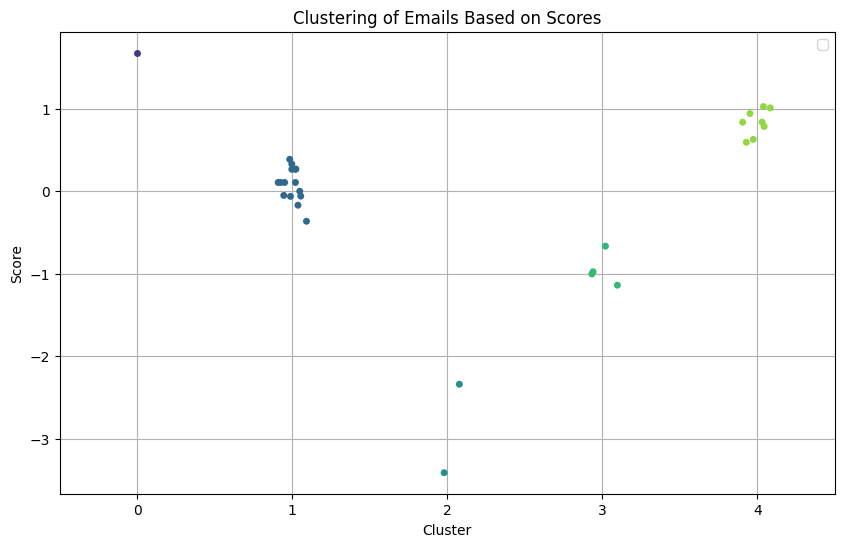

In [93]:
plt.figure(figsize=(10, 6))
sns.stripplot(x=df_agg["cluster"], y=df_agg["score_scaled"], jitter=True, palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Score")
plt.title("Clustering of Emails Based on Scores")
plt.legend()
plt.grid()
plt.show()

In [94]:
df_agg.query("cluster == 1")["email"]

0               adorado@berkeley.edu
1           anjalidixit@berkeley.edu
2             annacheng@berkeley.edu
4            brennandai@berkeley.edu
6             emilyynhi@berkeley.edu
7          ericwang0533@berkeley.edu
9                jtao22@berkeley.edu
14         mayurihebbar@berkeley.edu
20    preethi.rayaprolu@berkeley.edu
21        rahilisashaik@berkeley.edu
22             rpiao.26@berkeley.edu
24         saachi.goyal@berkeley.edu
26         shivanisahni@berkeley.edu
27           torinnayak@berkeley.edu
29             yashgk99@berkeley.edu
Name: email, dtype: object

##### Wow Leo has a mode of 1???

In [95]:
df_tst.query("email == 'leonardo.soffiatti@berkeley.edu'")["score"].mode()

0    1.0
Name: score, dtype: float64

##### Finally let's see how sexist we are as a club

In [96]:
def filter_source_files_between(df, lower, upper): # keep in mind that the soruce files start with 4
    df["file_num"] = df["source_file"].str.extract(r'(\d+)').astype(int)
    filtered_df = df[(df["file_num"] >= lower) & (df["file_num"] <= upper)]
    filtered_df = filtered_df.drop(columns=["file_num"])

    return filtered_df


In [97]:
df_agg_girl = filter_source_files_between(df_tst, 4, 80).groupby("email")["score"].mean().reset_index()
df_agg_girl.head()

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_1054/1055555342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["file_num"] = df["source_file"].str.extract(r'(\d+)').astype(int)


,email,score
0,adorado@berkeley.edu,3.062500
1,anjalidixit@berkeley.edu,2.789474
2,annacheng@berkeley.edu,3.437500
3,benjamin.liang@berkeley.edu,2.500000
4,brennandai@berkeley.edu,3.210526


In [98]:
df_agg_guy = filter_source_files_between(df_tst, 80, 196).groupby("email")["score"].mean().reset_index()
df_agg_guy.head()

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_1054/1055555342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["file_num"] = df["source_file"].str.extract(r'(\d+)').astype(int)


,email,score
0,adorado@berkeley.edu,3.081081
1,anjalidixit@berkeley.edu,3.026316
2,annacheng@berkeley.edu,2.800000
3,benjamin.liang@berkeley.edu,2.696970
4,brennandai@berkeley.edu,2.891892


In [99]:
merged_df = pd.merge(df_agg_girl, df_agg_guy, on="email", suffixes=("_df_girl", "_df_guy"))
merged_df["abs_difference"] = abs(merged_df["score_df_girl"] - merged_df["score_df_guy"])


In [100]:
max_difference = merged_df["abs_difference"].max()
max_diff_emails = merged_df[merged_df["abs_difference"] == max_difference]

print(f"Maximum Absolute Difference: {max_difference}")
print("Email(s) with Maximum Difference:")
print(max_diff_emails)

Maximum Absolute Difference: 0.6375000000000002
Email(s) with Maximum Difference:
                    email  score_df_girl  score_df_guy  abs_difference
2  annacheng@berkeley.edu         3.4375           2.8          0.6375


In [101]:
merged_df.sort_values(by="abs_difference", ascending=False).head()

,email,score_df_girl,score_df_guy,abs_difference
2,annacheng@berkeley.edu,3.437500,2.800000,0.637500
18,mayurihebbar@berkeley.edu,3.111111,2.500000,0.611111
10,jtao22@berkeley.edu,3.315789,2.742857,0.572932
22,nolancostin@berkeley.edu,3.111111,2.555556,0.555556
32,shivanisahni@berkeley.edu,3.388889,2.894737,0.494152


##### Let's try Vedant's approach now

##### Finally, let's assess voter fatigue

In [117]:
df_tst

,email,score,source_file,file_num
0,lilianxu@berkeley.edu,2.0,name_196.csv,196
1,mayurihebbar@berkeley.edu,NaN,name_196.csv,196
2,shivanisahni@berkeley.edu,3.0,name_196.csv,196
3,annacheng@berkeley.edu,1.0,name_196.csv,196
4,emilyynhi@berkeley.edu,2.0,name_196.csv,196
...,...,...,...,...
189805,NaN,NaN,name_4.csv,4
189806,NaN,NaN,name_4.csv,4
189807,NaN,NaN,name_4.csv,4
189808,NaN,NaN,name_4.csv,4


In [186]:
variance_by_file = df_tst.dropna(subset=["score"]).groupby("file_num")["score"].var()
mean_by_file = df_tst.query.dropna(subset=["score"]).groupby("file_num")["score"].mean()

In [187]:
coeffs = np.polyfit(variance_by_file.index, variance_by_file.values, deg=1)
trend_line_var = np.polyval(coeffs, variance_by_file.index)

coeffs = np.polyfit(mean_by_file.index, mean_by_file.values, deg=1)
trend_line_mean = np.polyval(coeffs, mean_by_file.index)

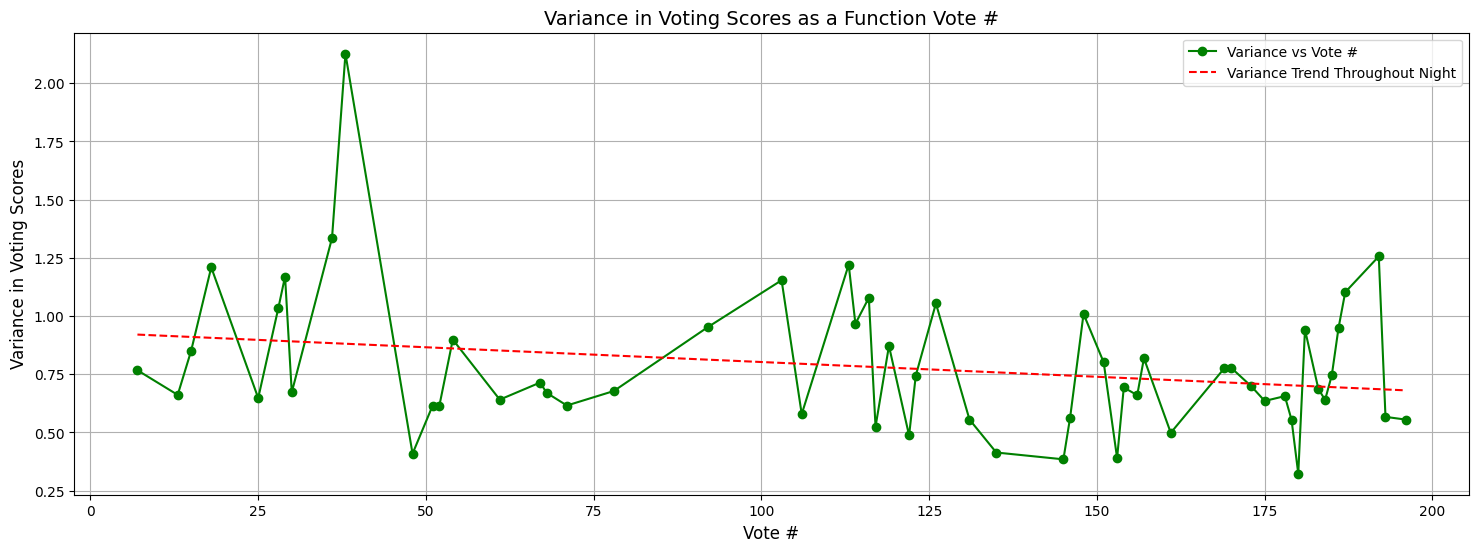

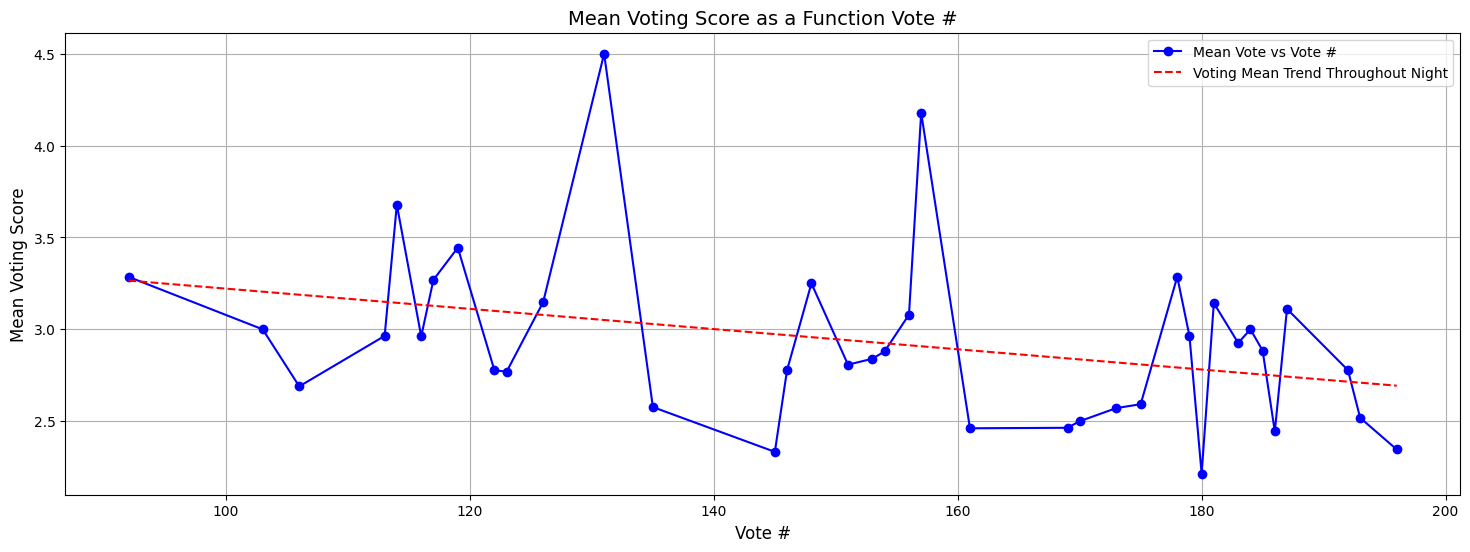

In [188]:
plt.figure(figsize=(18, 6))
plt.plot(variance_by_file.index, variance_by_file.values, marker="o", linestyle="-", color="green", label = "Variance vs Vote #")
plt.plot(variance_by_file.index, trend_line_var, color="red", linestyle="--", label="Variance Trend Throughout Night")
plt.title("Variance in Voting Scores as a Function Vote #", fontsize=14)
plt.xlabel("Vote #", fontsize=12)
plt.ylabel("Variance in Voting Scores", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(18, 6))
plt.plot(mean_by_file.index, mean_by_file.values, marker="o", linestyle="-", color="blue", label = "Mean Vote vs Vote #")
plt.plot(mean_by_file.index, trend_line_mean, color="red", linestyle="--", label="Voting Mean Trend Throughout Night")
plt.title("Mean Voting Score as a Function Vote #", fontsize=14)
plt.xlabel("Vote #", fontsize=12)
plt.ylabel("Mean Voting Score", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()


##### Now let's see which voters are most correlated

In [174]:
df_tst.head(5)

,email,score,source_file,file_num
0,lilianxu@berkeley.edu,2.0,name_196.csv,196
1,mayurihebbar@berkeley.edu,NaN,name_196.csv,196
2,shivanisahni@berkeley.edu,3.0,name_196.csv,196
3,annacheng@berkeley.edu,1.0,name_196.csv,196
4,emilyynhi@berkeley.edu,2.0,name_196.csv,196


In [175]:
def compute_correlation(df: pd.DataFrame, email_a: str, email_b: str):

    ts_1 = df[df["email"] == email_a]
    ts_2 = df[df["email"] == email_b]

    df_both = pd.merge(ts_1, ts_2, on='source_file', suffixes=("_left", "_right"))
    
    filtered = df_both.dropna(subset=["score_left", "score_right"])
    
    if len(filtered) > 1: 
        return filtered[["score_left", "score_right"]].corr().iloc[0, 1]
    else:
        return None  

In [179]:
email_list = df_tst["email"].dropna().unique()  # Exclude NaN emails
email_pairs = list(combinations(email_list, 2))  # Generate all unique pairs of emails

correlations = []
for email_a, email_b in email_pairs:
    try:
        corr = compute_correlation(df_tst, email_a, email_b)
        if corr is not None: 
            correlations.append({"Email_A": email_a, "Email_B": email_b, "Correlation": corr})
    except Exception as e:
        print(f"Error calculating correlation for {email_a} and {email_b}: {e}")


correlation_df = pd.DataFrame(correlations)
correlation_df = correlation_df.sort_values(by="Correlation", ascending=False)

In [201]:
correlation_df.query("Email_A == 'rahilisashaik@berkeley.edu' or Email_B == 'rahilisashaik@berkeley.edu'").sort_values(by="Correlation", ascending=False).head()

,Email_A,Email_B,Correlation
310,rahilisashaik@berkeley.edu,katiezchang@berkeley.edu,0.482925
115,emilyynhi@berkeley.edu,rahilisashaik@berkeley.edu,0.406761
302,rahilisashaik@berkeley.edu,vkumud@berkeley.edu,0.374979
314,rahilisashaik@berkeley.edu,mpjames5468@berkeley.edu,0.362213
306,rahilisashaik@berkeley.edu,jimmyzhong@berkeley.edu,0.352415
